<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/Week3/GravitationalWavesSanne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes
\begin{equation}
\begin{split}
s(t)&=n(t)+h(t)\\
\frac{1}{T}\int_0^Ts(t)h(t)dt&=\frac{1}{T}\int_0^Tn(t)h(t)dt+\frac{1}{T}\int_0^Th^2(t)dt=
\end{split}
\end{equation}

|||
|---|---|
|Names|GW170917|
|Event|GW170917-v1|
|GPS|1187008882.4|
|UTC time|2017-08-17 12:41|

In [5]:
# import sys
# !{sys.executable} -m pip install lalsuite==7.11 pycbc 
# %pip install gwpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
# Data 
import numpy as np
import pandas as pd

# Plotting and display
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import pylab

# Constants
from astropy.constants import M_sun

# gwpy
import gwpy
from gwpy.timeseries import TimeSeries

# pycbc
from pycbc import catalog
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t, matched_filter
from pycbc.catalog import Merger
from pycbc.psd import interpolate
from pycbc.types import TimeSeries

# gwosc
from gwosc.datasets import find_datasets, event_gps, run_segment
from gwosc import datasets

#lal
import lal
import lalsimulation
import lalframe 

Download the data set from [1]. This data set contains a noise time series and an addi- tional gravitational wave signal, where the <b>sampling rate of the time series is 16384Hz</b>.The first column of the data set refers to the time. The second and third columns are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of convenience in data analysis, we <b>downsample the data at a sampling rate of 2048Hz</b>.


Write down the code to calculate the matched filter between the given data and a
template waveform. After that, find out the template waveform for which the signal to noise ratio is maximum. For simplicity, you can assume the template waveform is produced from an equal mass binary system. Produce a plot which shows the SNR versus total mass of the system, where masses of the systems are uniformly distributed in a range 1M ≤ m1,2 ≤ 3M (use m1 = m2). Represent the result by fitting the best match template waveform against the data. Also, show the chirp structure of the signal over the time-frequency domain using Q-transformation().


•Here, we would like to investigate the correlation in the parameter space of gravitational waves from compact binary coalescences. Let us consider a gravitational wave h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want to understand how the nearby templates are correlated with that waveform. Calculate the match between h∗(t; m1,m2) and the nearby templates that are generated assuming 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1) when hi = h∗. You will see that the match between two nearby waveforms is not zero. So, one can realize the gravitational waveforms are correlated for two nearby points in the parameter space. This fact is used to produce a template bank for detecting gravitational waves.

### Merger

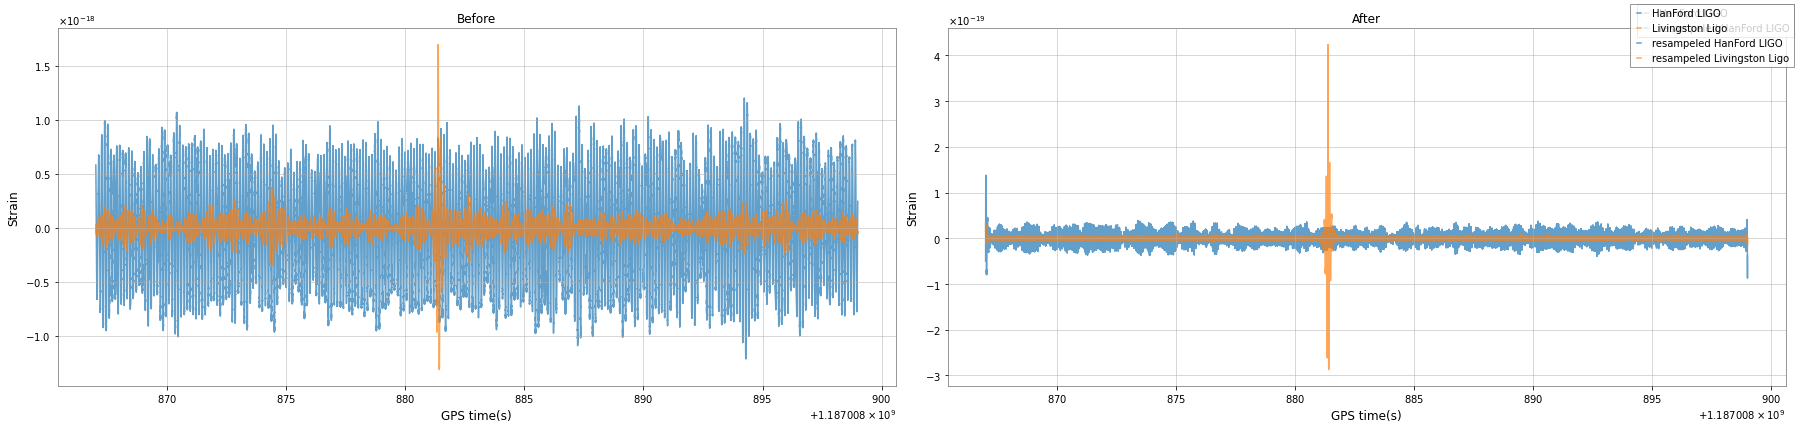

In [7]:
merger = Merger("GW170817")

detectors={"H1":"HanFord LIGO","L1":"Livingston Ligo"}

fig, ax = plt.subplots(figsize=(25,6),nrows=1, ncols=2, tight_layout=True)
for key,loc  in zip([k for k in detectors.keys()], [detectors[i]for i in detectors.keys()] ):
    strain = merger.strain(f"{key}")
    ax[0].plot(strain.sample_times, strain, label=f"{loc}", alpha=0.7)

    strain = resample_to_delta_t(highpass(strain,15),1/2048)
    ax[1].plot(strain.sample_times, strain, label=f"resampeled {loc}", alpha=0.7)

    ax[0].set_xlabel("GPS time(s)"),ax[1].set_xlabel("GPS time(s)")
    ax[0].set_ylabel("Strain"), ax[1].set_ylabel("Strain")
    ax[0].set_title("Before")
    ax[1].set_title("After")
    fig.legend()
fig.show()

(-0.1, 0.0)

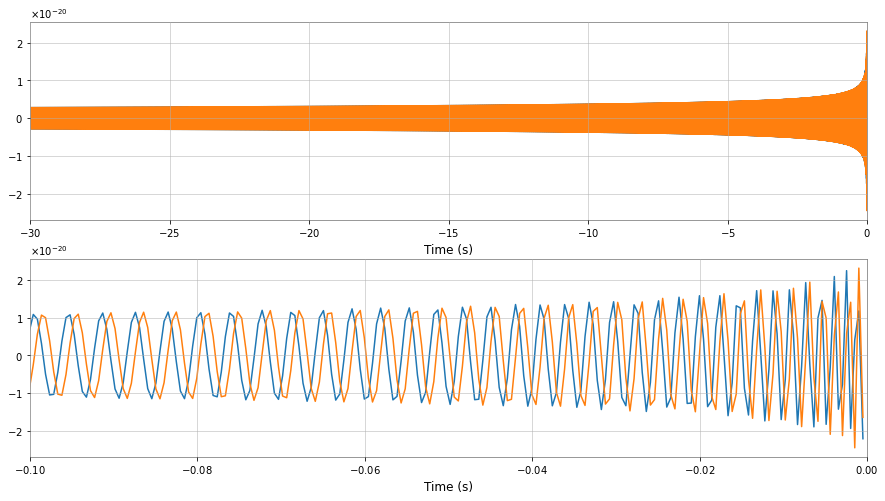

In [ ]:
hp,hc=get_td_waveform(approximant='TaylorT2',
                      mass1 = 2,
                      mass2 = 2, 
                      f_lower = 30,
                      delta_t = 1/2048)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8))

ax[0].plot(hp.sample_times, hp, label='Plus Polarization')
ax[0].plot(hp.sample_times, hc, label='Cross Polarization')
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim(-30,0)

ax[1].plot(hp.sample_times, hp, label='Plus Polarization')
ax[1].plot(hp.sample_times, hc, label='Cross Polarization')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim(-0.1,0)


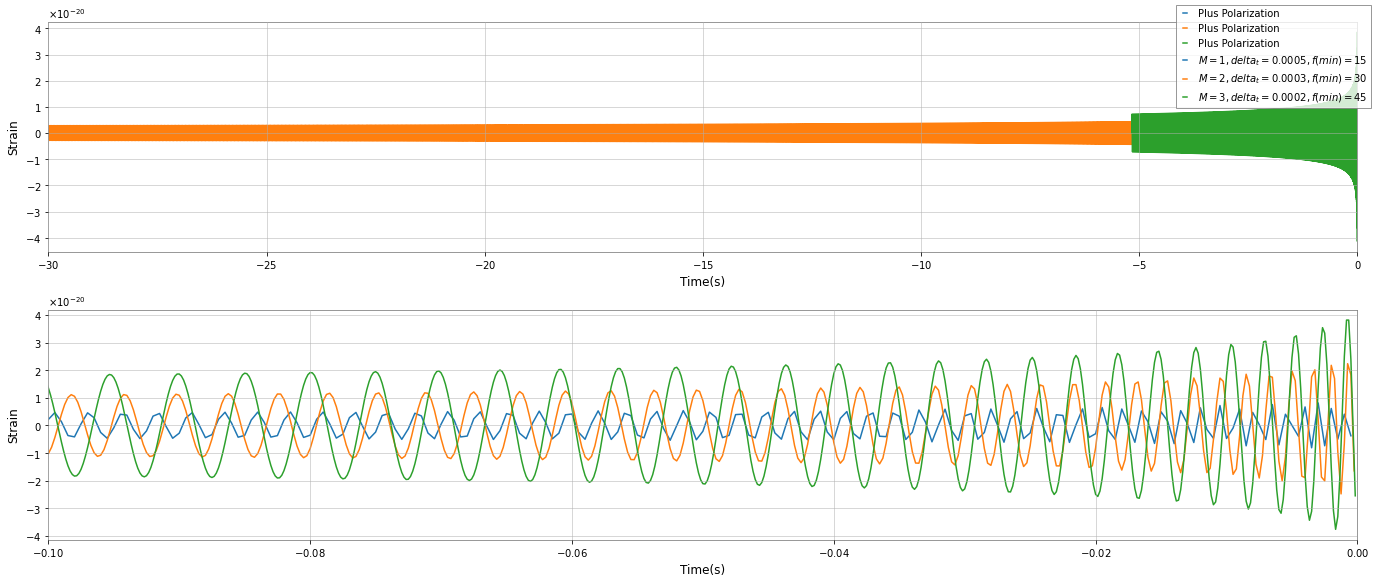

In [ ]:
from matplotlib.pylab import subplots
def fit(m, t, f, ax1,ax2):
  hp,hc=get_td_waveform(approximant='TaylorT2',mass1 = m,mass2 = m, f_lower =f,delta_t = t)
  return ax1.plot(hp.sample_times, hp, 
                  label='Plus Polarization'), ax2.plot(hp.sample_times, 
                                                       hc, label=f'$M={round(m,4)}, delta_t={round(t,4)}, f(min)={round(f,4)}$')

fig  = plt.figure(figsize=(19,8), constrained_layout=True)
ax1,ax2=fig.subplots(ncols=1,nrows=2)
ax1.set_xlim((-30,0))
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Strain")

ax2.set_xlim((-0.1,0))
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("Strain")

masses=[1,2,3]
frequencies=[15,30,45]
intervals=[1/2000,1/4000,1/6000]
for m,f,t in zip(masses,frequencies,intervals):
  a, b = fit(m, t, f, ax1, ax2)

fig.legend()


In [ ]:
m=catalog.Merger("GW170817")

d = np.array([[n, m.data[n]] for n in m.data.keys()], dtype='object')
df = pd.DataFrame(d)
HTML(df.to_html(notebook=True, index=False, header=False))

GPS,1187008882.4
catalog.shortName,GWTC-1-confident
chi_eff,0.0
chi_eff_lower,-0.01
chi_eff_unit,
chi_eff_upper,0.02
chirp_mass,None
chirp_mass_lower,None
chirp_mass_source,1.186
chirp_mass_source_lower,-0.001
chirp_mass_source_unit,M_sun


### Numpy

In [9]:
d = np.load('/content/drive/MyDrive/GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = TimeSeries(d[:, 1], delta_t = dt[1]- dt[0], epoch=dt[0]) #this is to comvert data into GW timeSeries
data_L1 = TimeSeries(d[:, 2], delta_t = dt[1]- dt[0], epoch=dt[0]) #this is to comvert data into GW timeSeries

strain["H1"] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()

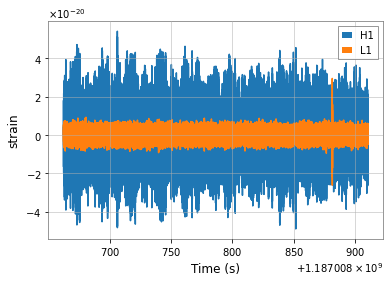

In [10]:
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

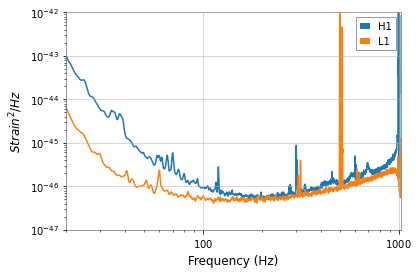

In [13]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = {}
for i in ["H1", "L1"]:
  psd[i]= interpolate(strain[i].psd(2), stilde[i].delta_f)
  psd[i] = inverse_spectrum_truncation(psd[i], int(2 * strain[i].sample_rate),
                                    low_frequency_cutoff=15, trunc_method='hann')

  pylab.loglog(psd[i].sample_frequencies, psd[i], label=i)
  pylab.ylabel('$Strain^2 / Hz$')
  pylab.xlabel('Frequency (Hz)')
  pylab.xlim(20, 1024)
  pylab.ylim(1e-47, 1e-42)
pylab.legend()
pylab.show()


In [18]:
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []
for m in np.arange(1,3, 0.01):
  snr_max, time_max = {}, {}
  hp , hc = get_fd_waveform(approximant='TaylorF2',
                          mass1 = m,
                          mass2 = m, 
                          f_lower = 20, 
                          delta_f = stilde["H1"].delta_f)
  
  hp.resize(len(stilde["H1"]))

  for i in ["H1", "L1"]:
    snr = matched_filter(hp, 
                         stilde[i], 
                         psd=psd[i], 
                         low_frequency_cutoff = 20)
    
    snr = snr.time_slice(merger.time - 1, merger.time + 1)
    _ , idx = snr.abs_max_loc()
    snr_max[i] = snr[idx]
    time_max[i] = float(idx)/snr.sample_rate+snr.start_time

  network_snr = (abs(np.array(list(snr_max.values())))**2.0).sum()**0.5
  snrs.append(snr_max)

  if network_snr > nsnr:
    hmax = hp 
    smax = snr_max
    tmax = time_max 
    mmax = m
    nsnr = network_snr


print(f"We found the best Mass1=Mass2 was {mmax} solar masses (detector frame)")

We found the best Mass1=Mass2 was 1.3800000000000003 solar masses (detector frame)


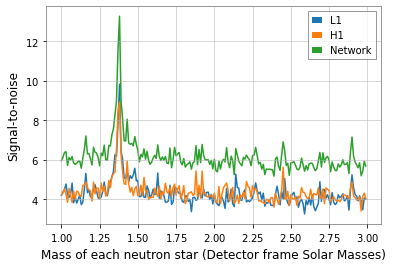

In [21]:
network_snrs = [abs(np.array(list(s.values()))**2.0).sum()**0.5 for s in snrs]
for ifo in ['L1', 'H1']:
    ind_snrs =  [abs(s[ifo]) for s in snrs]
    pylab.plot(np.arange(1,3,0.01), ind_snrs, label=ifo)
    
pylab.plot(np.arange(1,3,0.01), network_snrs, label='Network')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Mass of each neutron star (Detector frame Solar Masses)')
pylab.legend()

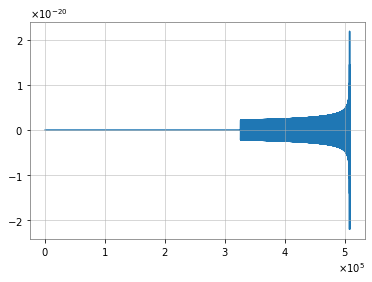

In [ ]:
hp,hc=get_td_waveform(approximant='TaylorT2',
                      mass1 = 2,
                      mass2 = 2, 
                      delta_t = strain["H1"].delta_t,
                      f_lower = 20)

hp.resize(len(strain["H1"]))
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)

pylab.show()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


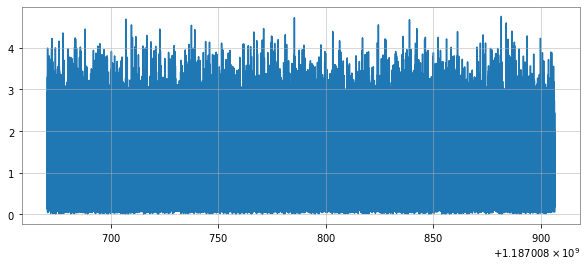

In [ ]:
snr = matched_filter(template, strain["H1"], psd=psd["H1"], low_frequency_cutoff=20)
snr = snr.crop(4+4, 4)

pylab.figure(figsize=[10,4])
pylab.plot(snr.sample_times, abs(snr))
pylab.show()

In [ ]:
H1, H2 = {}, {}

for i in [H1, H2]:
  i["string"]="hello"

print(H1)

{'string': 'hello'}
